In [2]:
from flask import Flask
from flask import jsonify
from flask import render_template
from flask import request
from flask import url_for
from flask import redirect

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn import neighbors

import db_conn

from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine


In [3]:
def create_earthquake_dict(r):
    return {
    "magnitude" : float(r[0]),
    "place": r[1],
    "time": int(r[2]),
    "timezone": float(r[3]),
    "url": r[4],
    "tsunami" :  int(r[5]),
    "id" : r[6],
    "specific_type" :  r[7],
    "title" :  r[8],
    "country" : r[9],
    "lat" : float(r[11]),
    "lng" :  float(r[10]),
    "depth" :  float(r[12])
    }

In [ ]:
sel = [db_conn.earthquakes.magnitude, db_conn.earthquakes.place, db_conn.earthquakes.time, db_conn.earthquakes.timezone, db_conn.earthquakes.url, db_conn.earthquakes.tsunami, db_conn.earthquakes.id, db_conn.earthquakes.specific_type, db_conn.earthquakes.title, db_conn.earthquakes.country_de, db_conn.earthquakes.lng, db_conn.earthquakes.lat, db_conn.earthquakes.depth]
all_results = db_conn.session.query(*sel).all()

all_earthquakes = []

for r in all_results:
    transformed_dict = create_earthquake_dict(r)
    all_earthquakes.append(transformed_dict)


df = pd.DataFrame(all_earthquakes)

In [ ]:
DROP_COLUMNS = ["place", "time", "timezone", "url",  "id", "specific_type", "title", "country"]
knn_df = df.drop(DROP_COLUMNS, axis = 1)

In [ ]:
def kNeighborAnalysis(X, y):

    ################ TRAIN TEST SPLIT ####################
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42)

    ################ K-NEAREST NEIGHBOR ####################
    training_accuracy = []
    test_accuracy = []
    confusion_matrix_arrays = []
    fpr_array = []
    tpr_array = []
    threshold_array = []

    # try n_neighbors from 1 to 10
    neighbors_settings = range(1, 11)

    for n_neighbors in neighbors_settings:
        # Instantiates the KNeighbor Model
        clf = KNeighborsClassifier(n_neighbors=n_neighbors)

        # Fits the model to the training data
        clf.fit(X_train, y_train)

        # record training set accuracy
        training_accuracy.append(clf.score(X_train, y_train))

        # record generalization accuracy
        test_accuracy.append(clf.score(X_test, y_test))

        # Compute Receiver operating characteristic (ROC)
        y_scores = clf.predict_proba(X_test)
        fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])

        # Listify the unpacked values
        fpr = fpr.tolist()
        tpr = tpr.tolist()
        threshold = threshold.tolist()
        
        # append values to an array
        fpr_array.append(fpr)
        tpr_array.append(tpr)
        threshold_array.append(threshold)

        # Computes the tn, fp, fn, tp in confusion matrix
        cm = confusion_matrix(y_test, clf.predict(X_test))
        tn, fp, fn, tp = cm.ravel()
        cm_list = [int(tn), int(fp), int(fn), int(tp)]
        confusion_matrix_arrays.append(cm_list)

    knn_annalysis_dict = {
        "x" : [1,2,3,4,5,6,7,8,9,10],
        "training_scores": training_accuracy,
        "test_scores": test_accuracy,
        "fpr_array" : fpr_array,
        "tpr_array" : tpr_array,
        "threshold_array" : threshold_array,
        "confusion_matrix_arrays" : confusion_matrix_arrays
        }

    return (knn_annalysis_dict)

In [ ]:
sel = [db_conn.earthquakes.magnitude, db_conn.earthquakes.place, db_conn.earthquakes.time, db_conn.earthquakes.timezone, db_conn.earthquakes.url, db_conn.earthquakes.tsunami, db_conn.earthquakes.id, db_conn.earthquakes.specific_type, db_conn.earthquakes.title, db_conn.earthquakes.country_de, db_conn.earthquakes.lng, db_conn.earthquakes.lat, db_conn.earthquakes.depth]


# Step 2: Run and store filtered query in results variable 
all_results = db_conn.session.query(*sel).all()

# Step 3: Build a list of dictionary that contains all the earthquakes
all_earthquakes = []

for r in all_results:
    transformed_dict = create_earthquake_dict(r)
    all_earthquakes.append(transformed_dict)


df = pd.DataFrame(all_earthquakes)

################ FEATURES PREPROCESSING FOR KNN MODEL ###################
DROP_COLUMNS = ["place", "time", "timezone", "url",  "id", "specific_type", "title", "country"]
knn_df = df.drop(DROP_COLUMNS, axis = 1)

# **************************************************** #
# ############### FEATURE SELECTION ################## #
# **************************************************** #

# Case 1: LNG, DEPTH, MAG
# CASE 2: LNG, DEPTH
# CASE 3: LNG, MAG
# CASE 4: DEPTH, MAG
# CASE 5: LNG,
# CASE 6: DEPTH
# CASE 7: MAG
# CASE 8: 

################# Lat "Lng Depth Magnitude" ###############
# CASE 1: ALL Subfeatures included: Lng Depth Magnitude
# CASE 1: ALL CHECKED OFF
# CASE 1: PREFIX DESIGNATION: All

# Step 1: Drop columns
# DEFAULT

# Step 2: Assign X and y values
y = knn_df["tsunami"].values
X = knn_df.drop('tsunami', axis=1).values
case1_df = knn_df.to_json(orient='values')


# Step 3: Conducted Analysis and store reust in variable
all_data = kNeighborAnalysis(X,y)

################# Lat "Lng Depth" ###############
# CASE 2: LNG, DEPTH CHECKED OFF
# CASE 2: MAGNITUDE NOT CHECKED OFF
# CASE 2: PREFIX DESIGNATION: lng_depth_df

# Step 1: Drop columns
CASE2_DROP_COLUMNS = ["magnitude"]
lng_depth_df = knn_df.drop(CASE2_DROP_COLUMNS, axis = 1)
case2_df = (knn_df.drop(CASE2_DROP_COLUMNS, axis = 1)).to_json(orient='values')

# Step 2: Assign X and y valuester
y = lng_depth_df["tsunami"].values
X = lng_depth_df.drop('tsunami', axis=1).values

# Step 3: Conducted Analysis and store reust in variable
lng_depth_data = kNeighborAnalysis(X,y)

################# Lat "Lng Magnitude" ###############
# CASE 3: LNG AND MAGNITUDE CHECKED OFF
# CASE 3: DEPTH NOT CHECKED OFF
# CASE 3: PREFIX DESIGNATION: lng_magnitude

# Step 1: Drop columns
CASE3_DROP_COLUMNS = ["depth"]
lng_magnitude_df = knn_df.drop(CASE3_DROP_COLUMNS, axis = 1)
case3_df = (knn_df.drop(CASE3_DROP_COLUMNS, axis = 1)).to_json(orient='values')

# Step 2: Assign X and y values
y = lng_magnitude_df["tsunami"].values
X = lng_magnitude_df.drop('tsunami', axis=1).values

# Step 3: Conducted Analysis and store reust in variable
lng_magnitude_data = kNeighborAnalysis(X,y)

################# Lat "Depth Magnitude" ###############
# CASE 4: DEPTH AND MAGNITUDE CHECKED OFF
# CASE 4: LNG NOT CHECKED OFF
# CASE 4: PREFIX DESIGNATION: depth_magnitude

# Step 1: Drop columns
CASE4_DROP_COLUMNS = ["lng"]
depth_magnitude_df = knn_df.drop(CASE4_DROP_COLUMNS, axis = 1)
case4_df = (knn_df.drop(CASE4_DROP_COLUMNS, axis = 1)).to_json(orient='values')

# Step 2: Assign X and y values
y = depth_magnitude_df["tsunami"].values
X = depth_magnitude_df.drop('tsunami', axis=1).values

# Step 3: Conducted Analysis and store reust in variable
depth_magnitude_data = kNeighborAnalysis(X,y)

################# Lat "Lng" ###############
# CASE 5: LNG CHECKED OFF
# CASE 5: MAGNITUDE AND DEPTH NOT CHECKED OFF
# CASE 5: PREFIX DESIGNATION: lng_df

# Step 1: Drop columns
CASE5_DROP_COLUMNS = ["magnitude", "depth"]
lng_df = knn_df.drop(CASE5_DROP_COLUMNS, axis = 1)
case5_df = (knn_df.drop(CASE5_DROP_COLUMNS, axis = 1)).to_json(orient='values')

# Step 2: Assign X and y values
y = lng_df["tsunami"].values
X = lng_df.drop('tsunami', axis=1).values

# Step 3: Conducted Analysis and store reust in variable
lng_data = kNeighborAnalysis(X,y)

################# Lat "Depth" ###############
# CASE 6: DEPTH CHECKED OFF
# CASE 6: LNG AND MAG NOT CHECKED OFF
# CASE 6: PREFIX DESIGNATION: depth

# Step 1: Drop columns
CASE6_DROP_COLUMNS = ["magnitude", "lng"]
depth_df = knn_df.drop(CASE6_DROP_COLUMNS, axis = 1)
case6_df = (knn_df.drop(CASE6_DROP_COLUMNS, axis = 1)).to_json(orient='values')

# Step 2: Assign X and y values
y = depth_df["tsunami"].values
X = depth_df.drop('tsunami', axis=1).values

# Step 3: Conducted Analysis and store reust in variable
depth_data = kNeighborAnalysis(X,y)

################# Lat "Magnitude" ###############
# CASE 7: MAGNITUDE CHECKED OFF
# CASE 7: LNG DEPTH NOT CHECKED OFF
# CASE 7: PREFIX DESIGNATION: magnitude

# Step 1: Drop columns
CASE5_DROP_COLUMNS = ["depth", "lng"]
magnitude_df = knn_df.drop(CASE5_DROP_COLUMNS, axis = 1)
case7_df = (knn_df.drop(CASE5_DROP_COLUMNS, axis = 1)).to_json(orient='values')

# Step 2: Assign X and y values
y = magnitude_df["tsunami"].values
X = magnitude_df.drop('tsunami', axis=1).values

# Step 3: Conducted Analysis and store reust in variable
magnitude_data = kNeighborAnalysis(X,y)

################# Lat ###############
# CASE 8: NO FEATURES SELECTED 
# CASE 8: ALL BOXED UNCHECKED
# CASE 8: PREFIX DESIGNATION: lat_df

# Step 1: Drop columns
DROP_NEW_COLUMNS = ["magnitude", "depth", "lng"]
lat_df = knn_df.drop(DROP_NEW_COLUMNS, axis = 1)
case8_df = (knn_df.drop(DROP_NEW_COLUMNS, axis = 1)).to_json(orient='values')

# Step 2: Assign X and y values
y = lat_df["tsunami"].values
X = lat_df.drop('tsunami', axis=1).values

# Step 3: Conducted Analysis and store reust in variable
lat_data = kNeighborAnalysis(X,y)


################# RETURNING ALL CASE RESULTS #########################
all_knn_analysis_data = {
    "case1" : all_data,
    "case2" : lng_depth_data,
    "case3" : lng_magnitude_data,
    "case4" : depth_magnitude_data,
    "case5" : lng_data,
    "case6" : depth_data, 
    "case7" : magnitude_data,
    "case8" : lat_data,
    "case1_df" : case1_df,
    "case2_df" : case2_df,
    "case3_df" : case3_df,
    "case4_df" : case4_df,
    "case5_df" : case5_df,
    "case6_df" : case6_df,
    "case7_df" : case7_df,
    "case8_df" : case8_df
}

In [53]:
sel = [db_conn.earthquakes.magnitude, db_conn.earthquakes.place, db_conn.earthquakes.time, db_conn.earthquakes.timezone, db_conn.earthquakes.url, db_conn.earthquakes.tsunami, db_conn.earthquakes.id, db_conn.earthquakes.specific_type, db_conn.earthquakes.title, db_conn.earthquakes.country_de, db_conn.earthquakes.lng, db_conn.earthquakes.lat, db_conn.earthquakes.depth]


# Step 2: Run and store filtered query in results variable 
all_results = db_conn.session.query(*sel).all()

# Step 3: Build a list of dictionary that contains all the earthquakes
all_earthquakes = []

for r in all_results:
    transformed_dict = create_earthquake_dict(r)
    all_earthquakes.append(transformed_dict)


df = pd.DataFrame(all_earthquakes)

In [54]:
################ FEATURES PREPROCESSING FOR KNN MODEL ###################
DROP_COLUMNS = ["place", "time", "timezone", "url",  "id", "specific_type", "title", "country"]
knn_df = df.drop(DROP_COLUMNS, axis = 1)

# Step 1: Drop columns
# DROP_NEW_COLUMNS = ["magnitude", "depth", "lng"]
DROP_NEW_COLUMNS = ["magnitude", "depth", "lng"]
new_df = knn_df.drop(DROP_NEW_COLUMNS, axis = 1)

In [55]:
new_df.head(n=1)

,lat,tsunami
0,69.1528,0


In [56]:
# Step 2: Assign X and y values
y = new_df["tsunami"]
X = new_df.drop('tsunami', axis=1)

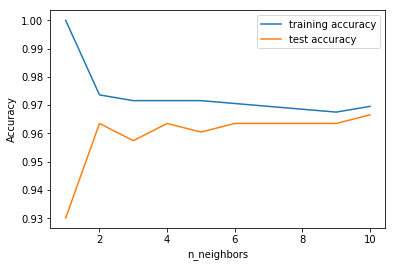

In [57]:
training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 11)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

for n_neighbors in neighbors_settings:
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))
    
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

n_neighbors = 5

# import some data to play with
iris = datasets.load_iris()

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
# X = iris.data[:, :2]
# y = iris.target

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for n_neighbors, ax in zip([1, 3, 9], axes):
    # the fit method returns the object self, so we can instantiate
    # and fit in one line
    clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X, y)
    mglearn.plots.plot_2d_separator(clf, X, fill=True, eps=0.5, ax=ax, alpha=.4)
    mglearn.discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
    ax.set_title("{} neighbor(s)".format(n_neighbors))
    ax.set_xlabel("feature Depth")
    ax.set_ylabel("feature Magnitude")
axes[0].legend(loc=3)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

n_neighbors = 15

# import some data to play with
iris = datasets.load_iris()

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

In [ ]:
h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()

# GENERAL LINEAR MACHINE LEARNING MODELS

In [ ]:
from sklearn.metrics import roc_curve
logreg = LogisticRegression()

y = plot2["tsunami"].values
X = plot2.drop(['tsunami'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr, label="Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.title("Logistic Regression ROC Curve")
plt.show()

In [ ]:
DROP_COLUMNS = ["ids", "geometry", "place", "url", "country", "specific_type", "time", "timezone", "lat", "lng"]
plot3 = df.drop(DROP_COLUMNS, axis = 1)
plot3.head()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

y = plot3["tsunami"].values
X = plot3.drop(['tsunami'], axis=1).values

In [ ]:



fig, axes = plt.subplots(1, 2, figsize=(10, 3))

for model, ax in zip([LinearSVC(), LogisticRegression()], axes):
    clf = model.fit(X, y)
    mglearn.plots.plot_2d_separator(clf, X, fill=False, eps=0.5,
                                    ax=ax, alpha=.7)
    mglearn.discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
    ax.set_title(clf.__class__.__name__)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
axes[0].legend()

In [ ]:
DROP_COLUMNS = ["ids", "geometry", "place", "url", "country", "specific_type", "time", "timezone", "lat", "lng"]
plot4 = df.drop(DROP_COLUMNS, axis = 1)

y = plot4["tsunami"].values
X = plot4.drop(['tsunami'], axis=1).values

In [ ]:
plot4.head()

In [ ]:
linear_svm = LinearSVC().fit(X, y)
print("Coefficient shape: ", linear_svm.coef_.shape)
print("Intercept shape: ", linear_svm.intercept_.shape)

In [ ]:
mglearn.plots.plot_2d_classification(linear_svm, X, fill=True, alpha=.7)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
line = np.linspace(-15, 15)
for coef, intercept, color in zip(linear_svm.coef_, linear_svm.intercept_,
                                  mglearn.cm3.colors):
    plt.plot(line, -(line * coef[0] + intercept) / coef[1], c=color)
plt.legend(['Class 0', 'Class 1', 'Class 2', 'Line class 0', 'Line class 1',
            'Line class 2'], loc=(1.01, 0.3))
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

In [ ]:
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

In [ ]:
import numpy as np
def compute_log_loss(predicted, actual, eps=1e-14):

    predicted = np.clip(predicted, eps, 1 - eps)
    loss = -1 * np.mean(actual * np.log(predicted) + (1 - actual) * np.log(1 - predicted))
    return loss

In [ ]:
compute_log_loss(0.996,0.995)

In [ ]:
# DROP_COLUMNS = ["ids", "geometry", "place", "url", "country", "specific_type", "timezone", "time", "depth"]
# tsnuma_mag = df.drop(DROP_COLUMNS, axis = 1)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

for model, ax in zip([LinearSVC(), LogisticRegression()], axes):
    clf = model.fit(X, y)
    mglearn.plots.plot_2d_separator(clf, X, fill=False, eps=0.5,
                                    ax=ax, alpha=.7)
    mglearn.discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
    ax.set_title(clf.__class__.__name__)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
axes[0].legend()

In [ ]:
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression

dummy = DummyClassifier().fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)
print("dummy score: {:.2f}".format(dummy.score(X_test, y_test)))

logreg = LogisticRegression(C=0.1).fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)
print("logreg score: {:.2f}".format(logreg.score(X_test, y_test)))

confusion = confusion_matrix(y_test, pred_logreg)
print("Confusion matrix:\n{}".format(confusion))

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for n_neighbors, ax in zip([1, 3, 9], axes):
    # the fit method returns the object self, so we can instantiate
    # and fit in one line
    clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X, y)
    mglearn.plots.plot_2d_separator(clf, X, fill=True, eps=0.5, ax=ax, alpha=.4)
    mglearn.discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
    ax.set_title("{} neighbor(s)".format(n_neighbors))
    ax.set_xlabel("feature 0")
    ax.set_ylabel("feature 1")
axes[0].legend(loc=3)